<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/Copy_of_1D_Diffusion_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pyDOE import lhs
from scipy.integrate import odeint
import time
import scipy.special as sp

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.__version__)
torch.manual_seed(31)
np.random.seed(31)

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=b11407e429fd5bb09088c1228d45ef394cfa7fdabb1100ebf4aefec37b130106
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
cuda
2.5.1+cu124


#Utils and MLP Class

In [2]:
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(layers)-2):
            z = self.linears[i](x)
            x = self.activation(z)
        x = self.linears[-1](x)
        return x

    def loss_bc_dirichlet(self, x, y):
        loss_d = self.loss_function(self.forward(x), y)
        return loss_d

    def loss_bc_neumann(self, x_neumann):
        x_neumann.requires_grad = True
        p = self.forward(x_neumann)
        p_grad = gradients(p, x_neumann)[0]
        p_x = p_grad[:, 0:1]
        loss_n = self.loss_function(p_x, torch.zeros_like(p_x))
        return loss_n

    def loss_internal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        p_grad = gradients(p, x_train)[0]
        c_x = p_grad[:, 0:1]
        c_t = p_grad[:, 1:2]
        c_xx = gradients(c_x, x_train)[0][:, 0:1]
        pde = c_t - D * c_xx
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, x_dirichlet, y_dirichlet, x_neumann, x_to_train_f):
        loss_D = self.loss_bc_dirichlet(x_dirichlet, y_dirichlet)
        loss_N = self.loss_bc_neumann(x_neumann)
        loss_F = self.loss_internal(x_to_train_f)
        return loss_D + loss_N + loss_F

def trainingdata(Nx, Nt, Nf, Nu_D, Nu_N):
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)
    init_cond = np.hstack((x[:, None], np.zeros((Nx, 1))))
    c_init = np.zeros((Nx, 1))
    left_bc = np.hstack((np.zeros((Nt, 1)), t[:, None]))
    c_left = c0 * np.ones((Nt, 1))
    bc_dirichlet = np.vstack((init_cond, left_bc))
    bc_c_dirichlet = np.vstack((c_init, c_left))
    idxD = np.random.choice(bc_dirichlet.shape[0], Nu_D)
    x_dirichlet = bc_dirichlet[idxD, :]
    y_dirichlet = bc_c_dirichlet[idxD, :]
    neumann_bc = np.hstack((np.ones((Nt, 1)), t[:, None]))
    idxN = np.random.choice(neumann_bc.shape[0], Nu_N)
    x_neumann = neumann_bc[idxN, :]
    f_train = lhs(2, Nf)
    return x_dirichlet, y_dirichlet, x_neumann, f_train

c0 = 1.0


#Data Prep and PINN Training

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 100, MSE: 0.155790
Epoch: 200, MSE: 0.051976
Epoch: 300, MSE: 0.037548
Epoch: 400, MSE: 0.026550
Epoch: 500, MSE: 0.019969
Epoch: 600, MSE: 0.015624
Epoch: 700, MSE: 0.012321
Epoch: 800, MSE: 0.010078
Epoch: 900, MSE: 0.008533
Epoch: 1000, MSE: 0.007111
Total training time in minutes: 0.3034597675005595


<ipython-input-3-b0adf33b18b1>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(path))
<ipython-input-3-b0adf33b18b1>:42: FutureWarning: You 

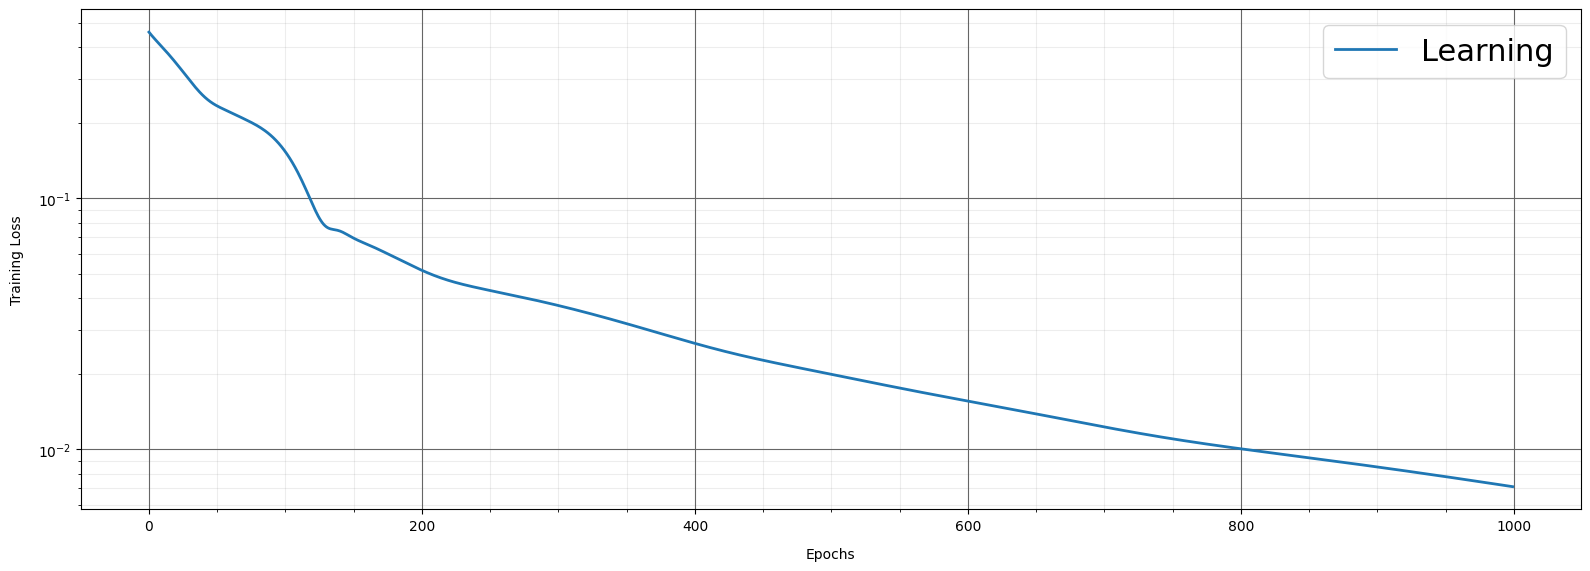

In [3]:
Nu_D = 300
Nu_N = 300
N_x = 100
N_t = 100
N_f = 10000

x_dirichlet_np, y_dirichlet_np, x_neumann_np, f_train_np = trainingdata(N_x, N_t, N_f, Nu_D, Nu_N)
x_dirichlet = nptoTensor(x_dirichlet_np)
y_dirichlet = nptoTensor(y_dirichlet_np)
x_neumann = nptoTensor(x_neumann_np)
f_train = nptoTensor(f_train_np)

D = 0.1
layers = np.array([2, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1])
mlp = MLP(layers).to(device)
step_size = 20000
gamma = 0.5
A_hist = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
max_iter = 1000

tic = time.time()
for i in range(max_iter):
    loss = mlp.loss(x_dirichlet, y_dirichlet, x_neumann, f_train)
    A_hist.append([i, loss.item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
         print("Epoch: {}, MSE: {:.6f}".format((i+1), loss.item()))
toc = time.time()
print(f'Total training time in minutes: {(toc-tic)/60}')

path = '1D-SoluteDiffusion_PDE_trained.pth'
torch.save(mlp.state_dict(), path)
path = '/content/1D-SoluteDiffusion_PDE_trained.pth'
mlp.load_state_dict(torch.load(path))
mlp.eval()

model = MLP(layers)
state_dict = torch.load('/content/1D-SoluteDiffusion_PDE_trained.pth')
model.load_state_dict(state_dict)
model.eval()
example = torch.rand(1, 2)
traced_script_module = torch.jit.trace(model, example)
torch.jit.save(traced_script_module, "SoluteDiffusion_PDE.pt")
loaded = torch.jit.load("SoluteDiffusion_PDE.pt")

A_hist = np.array(A_hist)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(visible=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
ax.plot(A_hist[:, 0], A_hist[:, 1], linewidth=2, label='Learning')
ax.legend(loc='best', frameon=True, fontsize=22)
ax.semilogy()
ax.set_xlabel('Epochs', labelpad=10)
ax.set_ylabel('Training Loss', labelpad=10)
plt.savefig('Activation.png', dpi=300, transparent=False, bbox_inches='tight')


#FDM Simulation


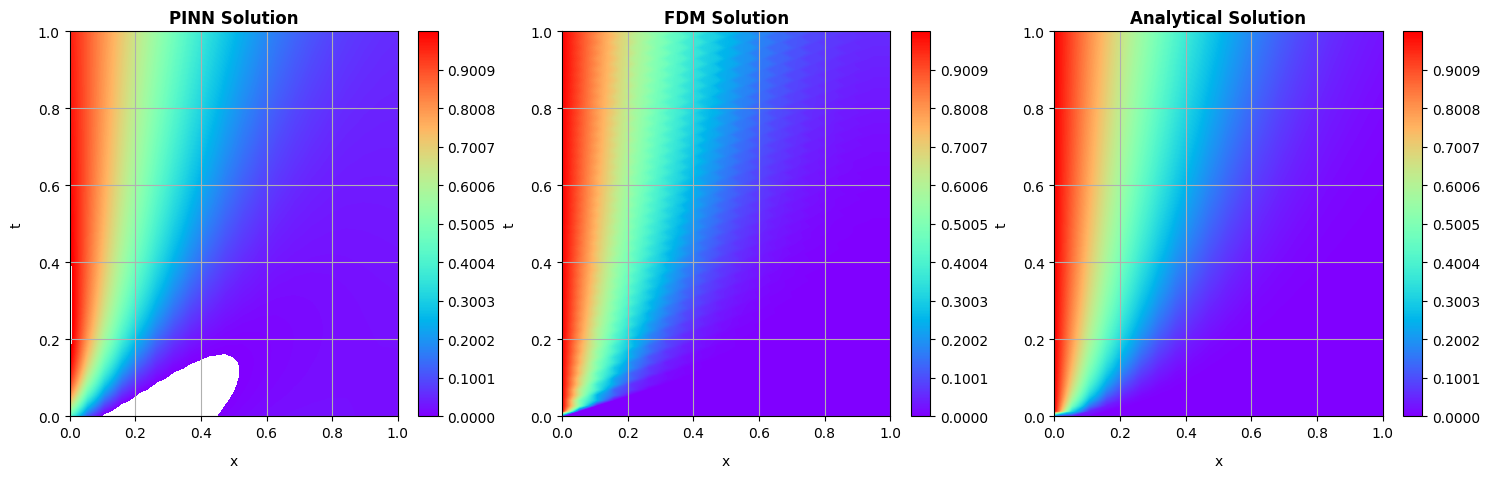

In [13]:
def central_difference(n, i, delta_x, delta_t, c):
    return c[n][i] + delta_t * (D * (c[n][i+1] - 2*c[n][i] + c[n][i-1])/(delta_x)**2)

points_in_x = 20
x = np.linspace(0, 1, points_in_x)
delta_x = x[1] - x[0]
delta_t = 0.5 * delta_x**2 / D
points_in_t = int(1.0/delta_t)
t = np.linspace(0, 1, points_in_t)
delta_t = t[1] - t[0]
c = np.zeros((len(t), len(x)))
c[0, :] = 0

for n in range(0, len(t)-1):
    c[n+1, 0] = c0
    for i in range(1, len(x)-1):
        c[n+1][i] = central_difference(n, i, delta_x, delta_t, c)
    c[n+1, -1] = c[n+1, -2]

X, T = np.meshgrid(x, t)
full_mesh = np.hstack([X.reshape(-1,1), T.reshape(-1,1)])
pinn_pred = eval_model(full_mesh).reshape(X.shape)

analytical_pred = np.array([[analytical_solution(xi, ti, D, c0) for xi in x] for ti in t])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = ['PINN Solution', 'FDM Solution', 'Analytical Solution']
data = [pinn_pred, c, analytical_pred]

for ax, d, title in zip(axes, data, titles):
    img = ax.contourf(x, t, d, levels=np.linspace(0, c0, 1000), cmap='rainbow')
    fig.colorbar(img, ax=ax)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('t', labelpad=10)
    ax.grid()

plt.savefig('1DSoluteDiffusion_Comparison.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()


# Evaluation/Basic Plots


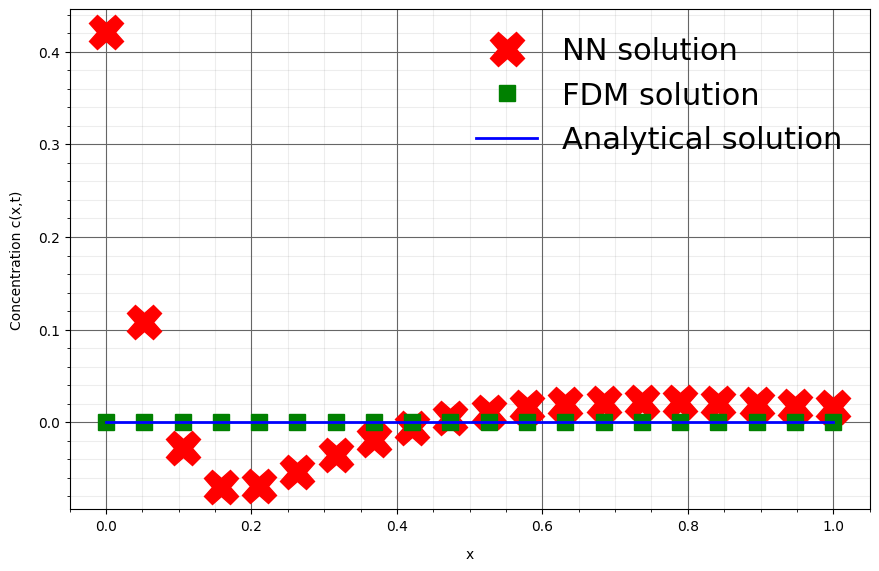

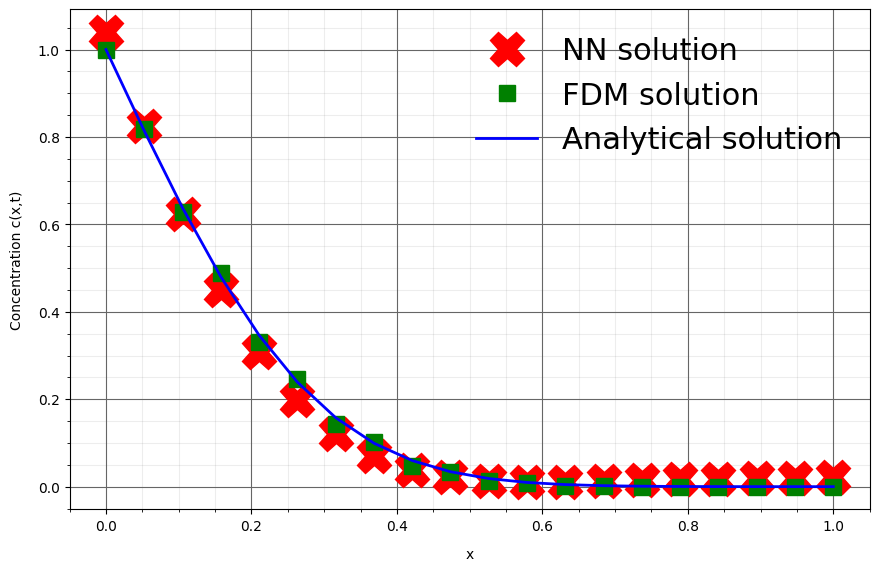

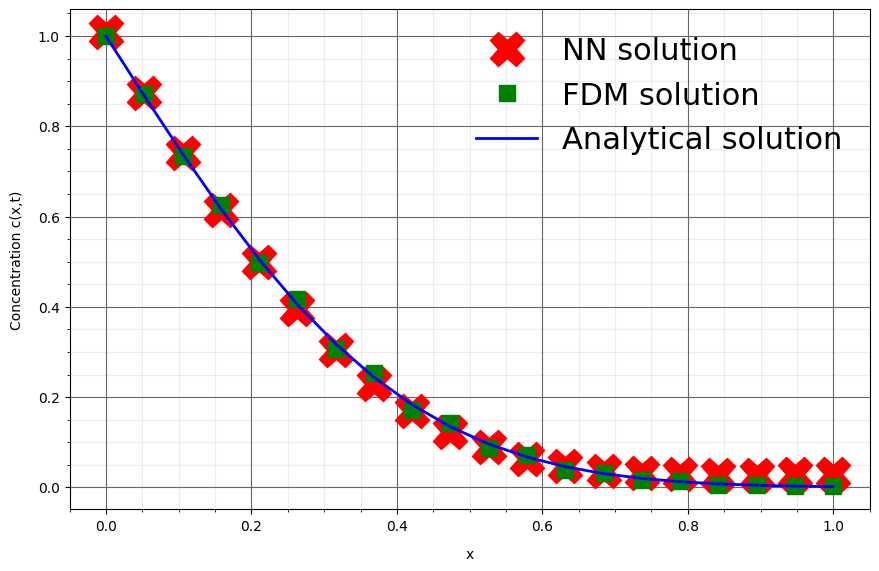

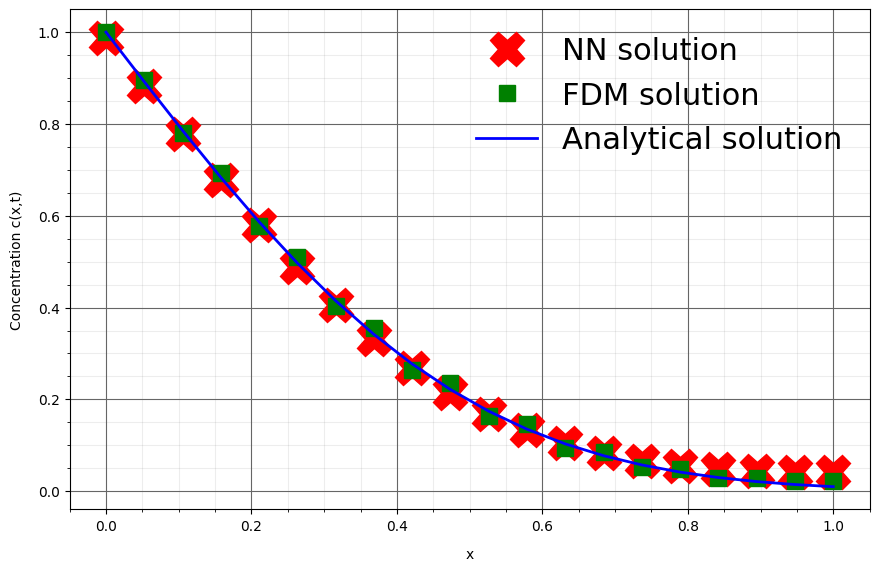

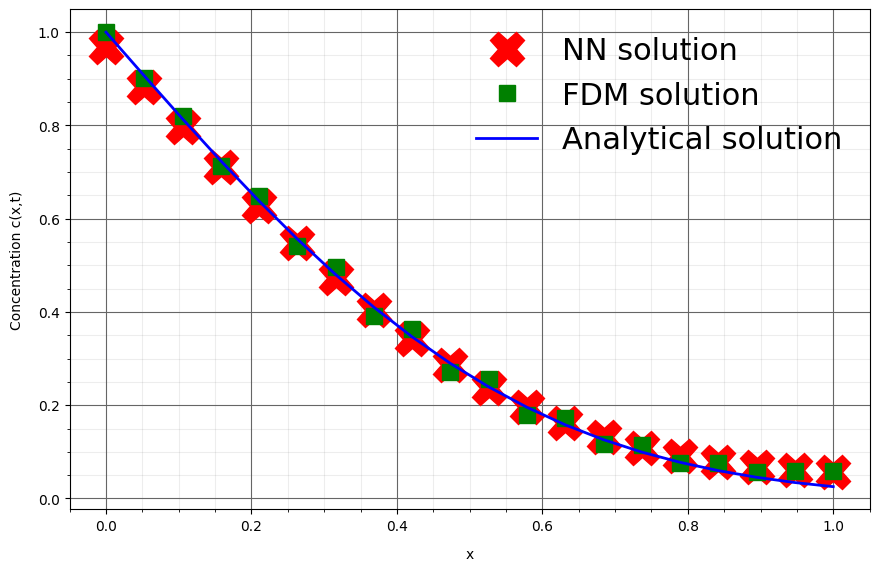

In [5]:
def build_mesh(N, t_val):
    x_vals = np.linspace(0, 1, N)
    _t = np.array([t_val])
    m = np.meshgrid(x_vals, _t)
    m = np.stack(m, -1).reshape(-1, 2)
    return x_vals, t_val, m

x1, t1, m1 = build_mesh(20, 0)
x2, t2, m2 = build_mesh(20, 0.25)
x3, t3, m3 = build_mesh(20, 0.5)
x4, t4, m4 = build_mesh(20, 0.75)
x5, t5, m5 = build_mesh(20, 1)

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

p1 = eval_model(m1)
p2 = eval_model(m2)
p3 = eval_model(m3)
p4 = eval_model(m4)
p5 = eval_model(m5)

def analytical_solution(x, t, D, c0):
    if t == 0:
        return np.zeros_like(x)
    return c0 * (1 - sp.erf(x / np.sqrt(4 * D * t)))

def plot_model(x_vals, p, t_val, c_fdm):
    c_analytical = analytical_solution(x_vals, t_val, D, c0)
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(x_vals, p, ms=25, marker='X', color='r', linestyle='None', label="NN solution")
    ax.plot(x_vals, c_fdm, ms=12, marker='s', color='g', linestyle='None', label="FDM solution")
    ax.plot(x_vals, c_analytical, 'b-', linewidth=2, label="Analytical solution")
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('Concentration c(x,t)', labelpad=10)
    ax.grid(visible=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
    ax.legend(loc='best', frameon=False, facecolor='#9BC7C8', framealpha=1, fontsize=22)
    plt.savefig(f"t = {t_val:.3f}.png", dpi=600, transparent=False, bbox_inches='tight')
    plt.show()

plot_model(x, p1, t1, c[0, :])
plot_model(x, p2, t2, c[int(0.25*len(t)), :])
plot_model(x, p3, t3, c[int(0.5*len(t)), :])
plot_model(x, p4, t4, c[int(0.75*len(t)), :])
plot_model(x, p5, t5, c[-1, :])


#More plots

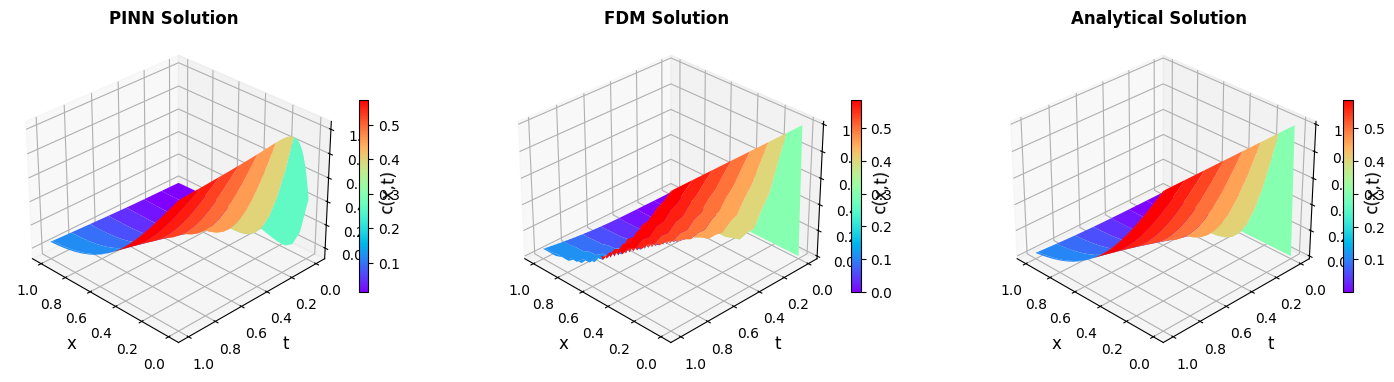

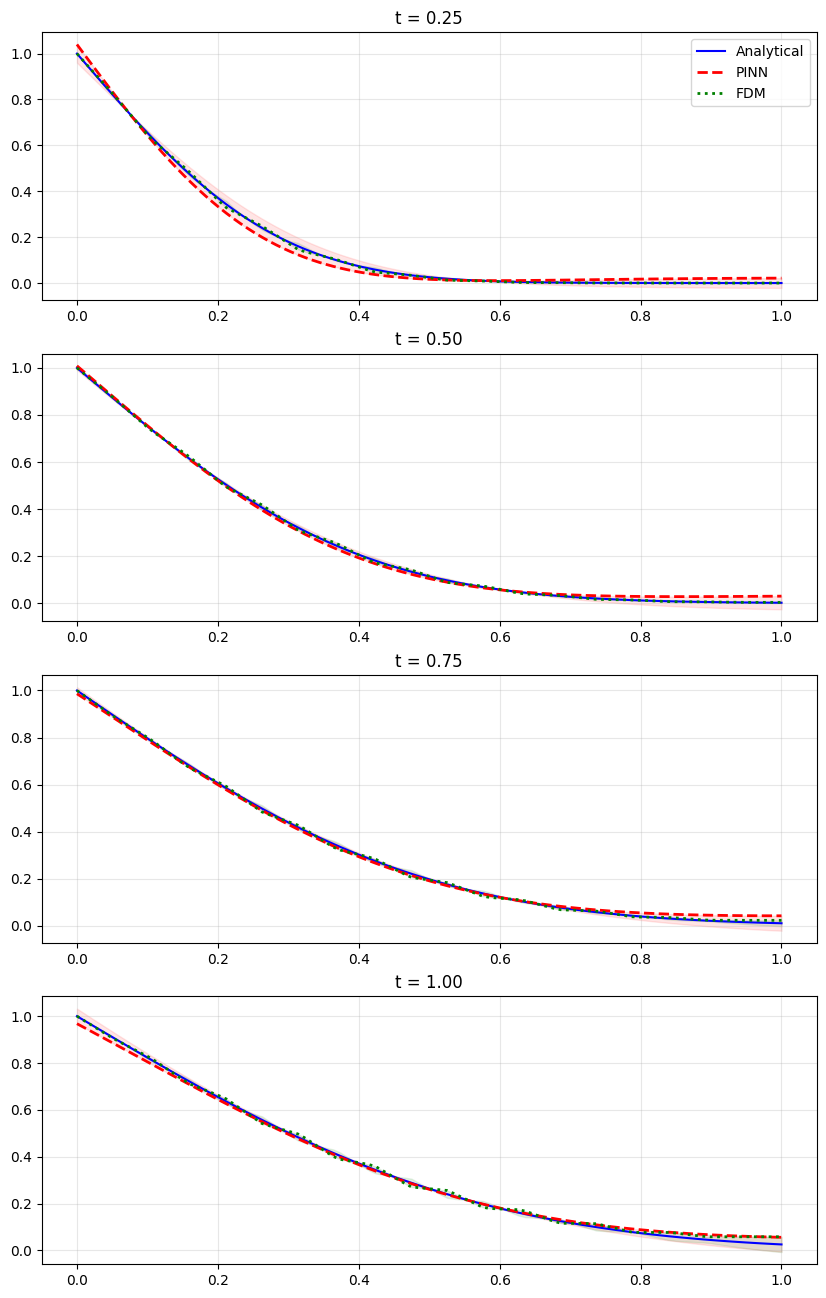

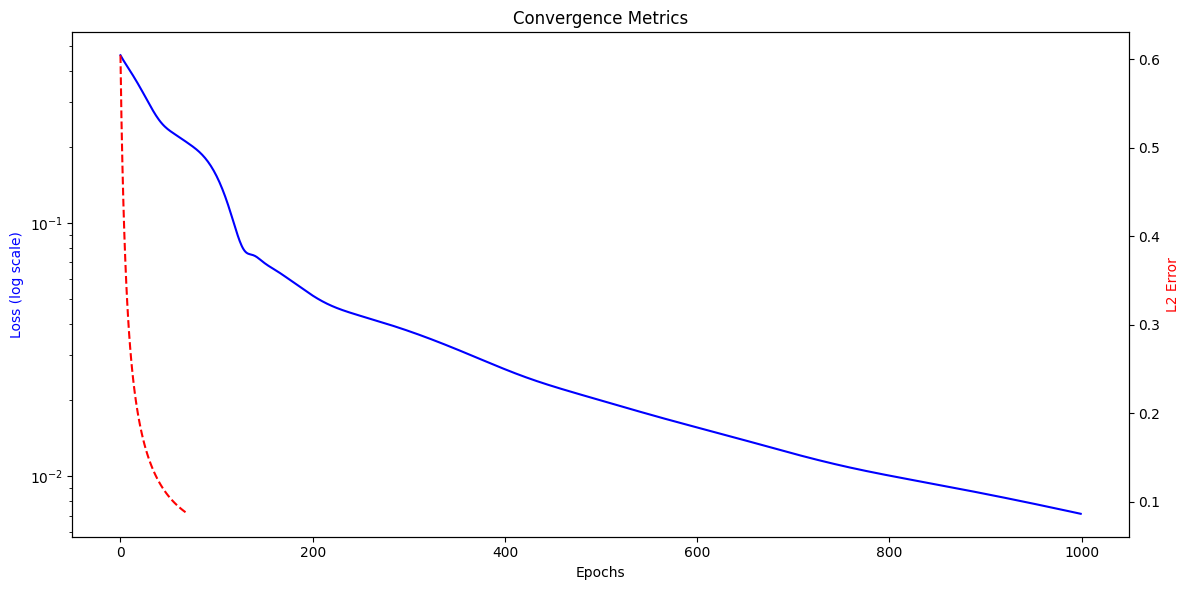

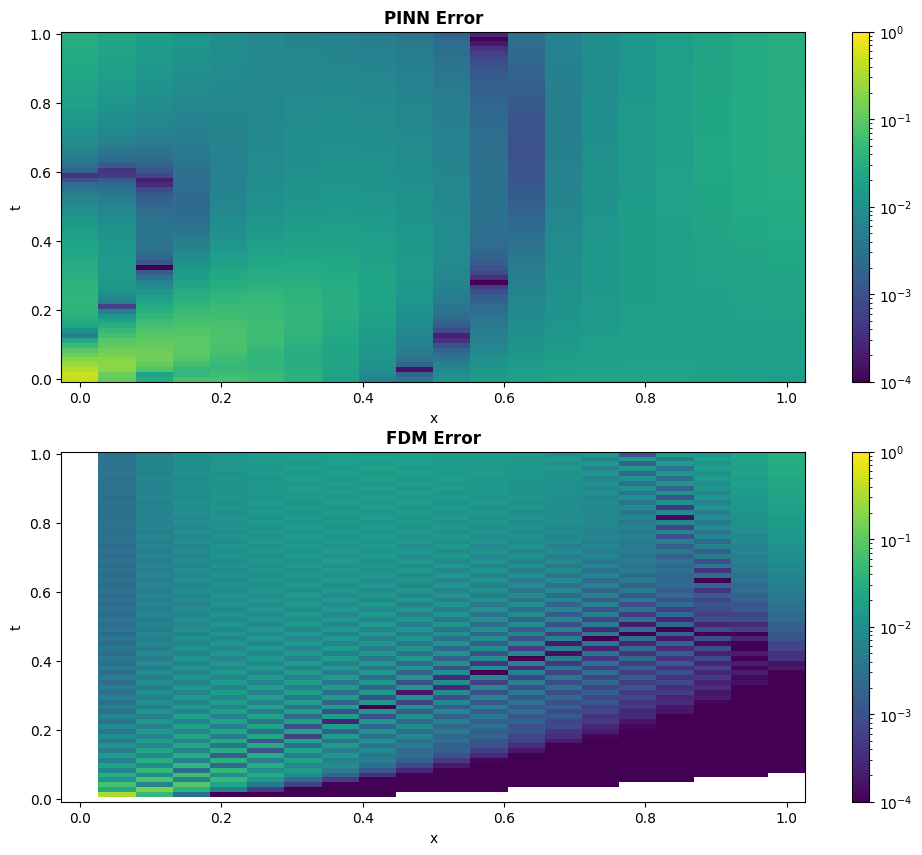

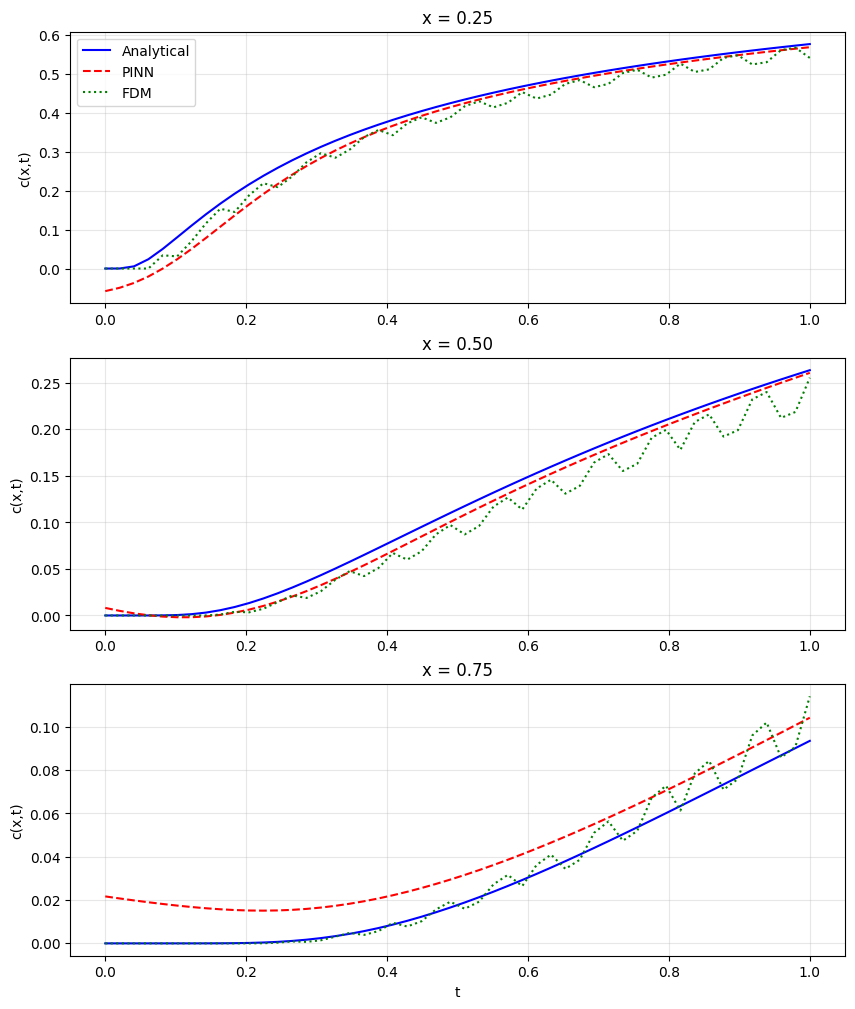

In [6]:
def plot_3d_surfaces():
    X, T = np.meshgrid(x, t)
    full_mesh = np.hstack([X.reshape(-1,1), T.reshape(-1,1)])
    pinn_pred = eval_model(full_mesh).reshape(X.shape)
    fig = plt.figure(figsize=(18,5))
    titles = ['PINN Solution', 'FDM Solution', 'Analytical Solution']
    data = [pinn_pred, c, np.array([[analytical_solution(xi, ti, D, c0) for xi in x] for ti in t])]
    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        surf = ax.plot_surface(X, T, data[i], cmap='rainbow', rstride=10, cstride=10)
        ax.view_init(30, 135)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('t', fontsize=12)
        ax.set_zlabel('c(x,t)', fontsize=12)
        ax.set_title(titles[i], fontweight='bold')
        fig.colorbar(surf, ax=ax, shrink=0.5)
    plt.savefig('3D_Surface_Comparison.png', dpi=300, bbox_inches='tight')

def plot_error_snapshots():
    times = [0.25, 0.5, 0.75, 1.0]
    fig, axs = plt.subplots(4, 1, figsize=(10, 16))
    x_fdm = np.linspace(0, 1, 20)
    for idx, t_val in enumerate(times):
        x_vals, _, mesh = build_mesh(100, t_val)
        pinn = eval_model(mesh).squeeze()
        fdm_idx = int(np.round(t_val * (len(t)-1)))
        fdm_native = c[fdm_idx, :]
        fdm = np.interp(x_vals, x_fdm, fdm_native).squeeze()
        analytic = analytical_solution(x_vals, t_val, D, c0).squeeze()
        axs[idx].plot(x_vals, analytic, 'b-', label='Analytical')
        axs[idx].plot(x_vals, pinn, 'r--', linewidth=2, label='PINN')
        axs[idx].plot(x_vals, fdm, 'g:', linewidth=2, label='FDM')
        pinn_err = np.abs(pinn - analytic)
        fdm_err = np.abs(fdm - analytic)
        axs[idx].fill_between(x_vals, analytic - pinn_err, analytic + pinn_err, color='r', alpha=0.1)
        axs[idx].fill_between(x_vals, analytic - fdm_err, analytic + fdm_err, color='g', alpha=0.1)
        axs[idx].set_title(f't = {t_val:.2f}', fontsize=12)
        axs[idx].grid(True, alpha=0.3)
        if idx == 0:
            axs[idx].legend(loc='upper right')
    plt.savefig('Multi_Time_Error_Snapshots.png', dpi=300, bbox_inches='tight')

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(A_hist[:,0], A_hist[:,1], 'b-', label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    X, T = np.meshgrid(x, t)
    full_mesh = np.hstack([X.reshape(-1,1), T.reshape(-1,1)])
    pinn_full = eval_model(full_mesh).reshape(X.shape)
    analytic_full = np.array([[analytical_solution(xi, max(ti,1e-6), D, c0) for xi in x] for ti in t])
    eps = 1e-12
    l2_errors = [np.linalg.norm(pinn_full[:i] - analytic_full[:i]) / (np.linalg.norm(analytic_full[:i]) + eps) for i in range(1, len(t))]
    ax2 = ax1.twinx()
    ax2.plot(l2_errors, 'r--', label='Relative L2 Error')
    ax2.set_ylabel('L2 Error', color='r')
    plt.title('Convergence Metrics')
    fig.tight_layout()
    plt.savefig('Convergence_Dashboard.png', dpi=300, bbox_inches='tight')

def plot_error_heatmaps():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    X, T = np.meshgrid(x, t)
    pinn_full = eval_model(np.hstack([X.reshape(-1,1), T.reshape(-1,1)])).reshape(X.shape)
    analytic_full = np.array([[analytical_solution(xi, ti, D, c0) for xi in x] for ti in t])
    pinn_err = np.abs(pinn_full - analytic_full)
    fdm_err = np.abs(c - analytic_full)
    for ax, data, title in zip([ax1, ax2], [pinn_err, fdm_err], ['PINN Error', 'FDM Error']):
        im = ax.pcolormesh(X, T, data, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1), cmap='viridis')
        fig.colorbar(im, ax=ax)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
    plt.savefig('Error_Heatmaps.png', dpi=300, bbox_inches='tight')

def plot_temporal_evolution():
    x_points = [0.25, 0.5, 0.75]
    fig, axs = plt.subplots(len(x_points), 1, figsize=(10, 12))
    x_fdm = np.linspace(0, 1, 20)
    for idx, x_val in enumerate(x_points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []
        for ti in t_vals:
            safe_t = max(ti, 1e-6) if ti == 0 else ti
            _, _, mesh = build_mesh(1, ti)
            mesh[:,0] = x_val
            pinn_t.append(eval_model(mesh)[0])
            analytic_t.append(analytical_solution(x_val, safe_t, D, c0))
            fdm_idx_t = int(np.round(ti * (len(t)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_t.append(c[fdm_idx_t, fdm_idx_x])
        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'x = {x_val:.2f}', fontsize=12)
        axs[idx].grid(True, alpha=0.3)
        axs[idx].set_ylabel('c(x,t)')
        if idx == 0:
            axs[idx].legend()
    axs[-1].set_xlabel('t')
    plt.savefig('Temporal_Evolution.png', dpi=300, bbox_inches='tight')

plot_3d_surfaces()
plot_error_snapshots()
plot_convergence_metrics()
plot_error_heatmaps()
plot_temporal_evolution()


#More

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=e4e8f0a90484daeeb0de55a3cb7388fbcb72a14bc65a07cbfbaa42014418d9ce
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
Using device: cuda
Epoch 100/1000, Loss: 0.111729
Epoch 200/1000, Loss: 0.018934
Epoch 300/1000, Loss: 0.016480
Epoch 400/1000, Loss: 0.015838
Epoch 500/1000, Loss: 0.015378
Epoch 600/1000, Loss: 0.015033
Epoch 700/1000, Loss: 0.014759
Epoch 800/1000, Loss: 0.014527
Epoch 900/1000, Loss: 0.014322
Epoch 1000/1000, Loss: 0.014132
Total training time: 0.48 minutes


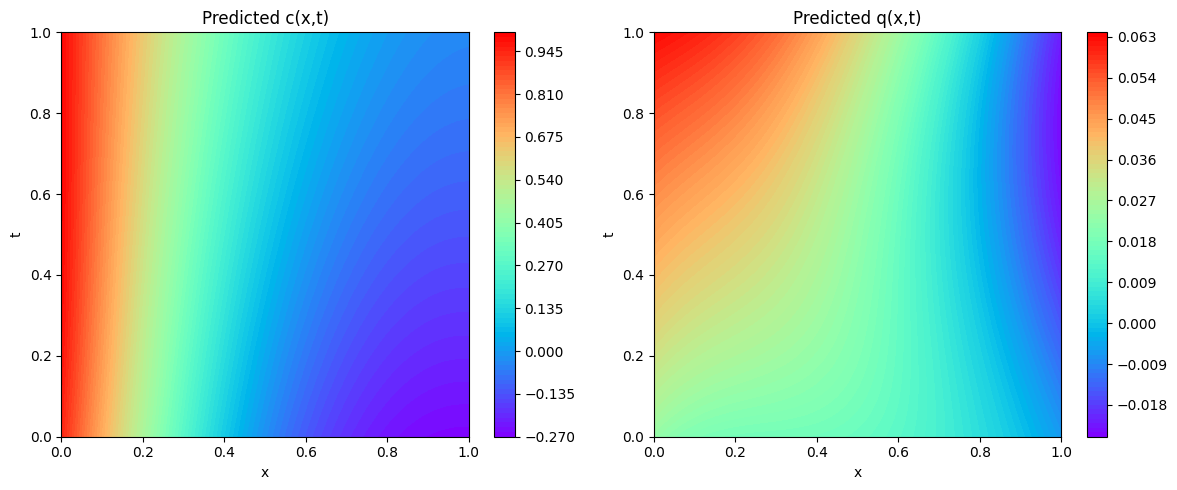

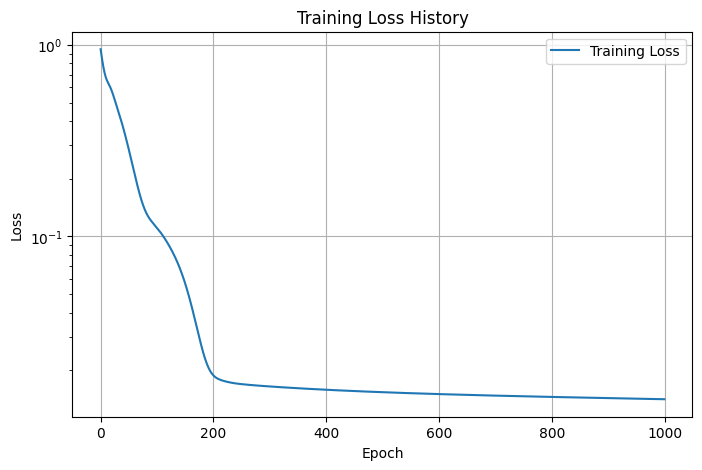

In [1]:
#%% Imports and Setup
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pyDOE import lhs
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
torch.manual_seed(31)
np.random.seed(31)

#%% Utility Functions
def gradients(outputs, inputs):
    # returns d(outputs)/d(inputs)
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

def nptoTensor(data):
    return torch.tensor(data, dtype=torch.float32, device=device)

def chi(x, solid_positions, delta):
    """
    Indicator function for the porous medium.
    x: tensor of spatial coordinates, shape (N,1)
    solid_positions: list of center positions for the solid nodes.
    delta: half-width of the solid region.
    Returns: tensor of the same shape as x, with values 1 (inside solid) or 0.
    """
    chi_val = torch.zeros_like(x)
    for xs in solid_positions:
        chi_val += ((x > (xs - delta)) & (x < (xs + delta))).float()
    return torch.clamp(chi_val, 0, 1)

#%% Physical Parameters and Pore Structure
D     = 0.1    # Diffusion coefficient
c0    = 1.0    # Dirichlet BC for c at x=0
k_ads = 1.0    # Adsorption rate constant
k_des = 0.1    # Desorption rate constant
q_sat = 1.0    # Saturation capacity

# Define solid node positions (pore structure) and half-width delta
solid_positions = [0.3, 0.6, 0.8]
delta = 0.02

#%% Define the PINN (MLP) with Two Outputs: c and q
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        for layer in self.linears:
            nn.init.xavier_normal_(layer.weight, gain=1.0)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        # x: (N,2) input (x, t)
        for layer in self.linears[:-1]:
            x = self.activation(layer(x))
        x = self.linears[-1](x)
        # Output shape: (N,2) where column 0 is c(x,t) and column 1 is q(x,t)
        return x

    def loss(self, x_bc_c, y_bc_c, x_bc_q, y_bc_q, x_neumann, x_colloc):
        # --- Dirichlet BC for c at x=0 (all t) ---
        out_bc = self.forward(x_bc_c)
        c_bc = out_bc[:, 0:1]
        loss_bc_c = self.loss_function(c_bc, y_bc_c)

        # --- Dirichlet BC for q at t=0 (all x) ---
        out_bc_q = self.forward(x_bc_q)
        q_bc = out_bc_q[:, 1:2]
        loss_bc_q = self.loss_function(q_bc, y_bc_q)

        # --- Neumann BC for c at x=1 (c_x=0) ---
        x_neumann.requires_grad = True
        out_neumann = self.forward(x_neumann)
        c_neumann = out_neumann[:, 0:1]
        c_neumann_grad = gradients(c_neumann, x_neumann)[:, 0:1]
        loss_neumann = self.loss_function(c_neumann_grad, torch.zeros_like(c_neumann_grad))

        # --- PDE Residual at Collocation Points ---
        x_colloc.requires_grad = True
        out_colloc = self.forward(x_colloc)
        c_colloc = out_colloc[:, 0:1]
        q_colloc = out_colloc[:, 1:2]

        # Derivatives for c
        c_grad = gradients(c_colloc, x_colloc)
        c_x = c_grad[:, 0:1]
        c_t = c_grad[:, 1:2]
        c_xx = gradients(c_x, x_colloc)[:, 0:1]

        # Time derivative for q
        q_grad = gradients(q_colloc, x_colloc)
        q_t = q_grad[:, 1:2]

        # Evaluate indicator function using spatial coordinate (first column)
        chi_val = chi(x_colloc[:, 0:1], solid_positions, delta)

        # Langmuir kinetics: R(c,q)
        R = k_ads * c_colloc * (1 - q_colloc / q_sat) - k_des * q_colloc

        # PDEs:
        # Fluid-phase: c_t = D c_xx - χ R  =>  c_t - D c_xx + χ R = 0
        # Solid-phase: q_t = χ R       =>  q_t - χ R = 0
        res_c = c_t - D * c_xx + chi_val * R
        res_q = q_t - chi_val * R
        loss_pde = (res_c**2).mean() + (res_q**2).mean()

        total_loss = loss_bc_c + loss_bc_q + loss_neumann + loss_pde
        return total_loss

#%% Generate Training Data for the Porous Medium Problem
def trainingdata_porous(Nx, Nt, Nf):
    # Dirichlet BC for c: at x=0 for t in [0,1]
    t_bc = np.linspace(0, 1, Nt)[:, None]
    x_bc_c = np.hstack((np.zeros((Nt, 1)), t_bc))
    y_bc_c = c0 * np.ones((Nt, 1))

    # Dirichlet BC for q: initial condition t=0 for x in [0,1]
    x_space = np.linspace(0, 1, Nx)[:, None]
    t_initial = np.zeros((Nx, 1))
    x_bc_q = np.hstack((x_space, t_initial))
    y_bc_q = np.zeros((Nx, 1))

    # Neumann BC for c: at x=1 for t in [0,1] (c_x=0)
    t_neumann = np.linspace(0, 1, Nt)[:, None]
    x_neumann = np.hstack((np.ones((Nt, 1)), t_neumann))

    # Collocation points in the interior using Latin Hypercube Sampling (domain: [0,1]x[0,1])
    f_train = lhs(2, Nf)

    return x_bc_c, y_bc_c, x_bc_q, y_bc_q, x_neumann, f_train

# Set numbers for BC and collocation points
Nx = 100
Nt = 100
Nf = 10000

x_bc_c_np, y_bc_c_np, x_bc_q_np, y_bc_q_np, x_neumann_np, f_train_np = trainingdata_porous(Nx, Nt, Nf)
x_bc_c = nptoTensor(x_bc_c_np)
y_bc_c = nptoTensor(y_bc_c_np)
x_bc_q = nptoTensor(x_bc_q_np)
y_bc_q = nptoTensor(y_bc_q_np)
x_neumann = nptoTensor(x_neumann_np)
x_colloc = nptoTensor(f_train_np)

#%% Instantiate the Network
# Architecture: input dim 2, output dim 2.
layers = [2, 32, 32, 32, 32, 32, 32, 32, 32, 32, 2]
model = MLP(layers).to(device)

#%% Training Loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
max_iter = 1000
loss_history = []

tic = time.time()
for i in range(max_iter):
    optimizer.zero_grad()
    loss = model.loss(x_bc_c, y_bc_c, x_bc_q, y_bc_q, x_neumann, x_colloc)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (i+1) % 100 == 0:
        print(f"Epoch {i+1}/{max_iter}, Loss: {loss.item():.6f}")
toc = time.time()
print(f"Total training time: {(toc-tic)/60:.2f} minutes")

# Save the trained model
model_path = "PorousSoluteTransport_PINN.pth"
torch.save(model.state_dict(), model_path)

#%% Evaluation and Visualization
model.eval()
# Create a mesh grid on [0,1] x [0,1]
points = 100
x_eval = np.linspace(0, 1, points)
t_eval = np.linspace(0, 1, points)
X, T = np.meshgrid(x_eval, t_eval)
eval_points = np.hstack((X.reshape(-1,1), T.reshape(-1,1)))
eval_tensor = nptoTensor(eval_points)

with torch.no_grad():
    output = model(eval_tensor)
    c_pred = output[:, 0].cpu().numpy().reshape(X.shape)
    q_pred = output[:, 1].cpu().numpy().reshape(X.shape)

# Plot c(x,t) and q(x,t)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cs0 = axes[0].contourf(X, T, c_pred, levels=100, cmap='rainbow')
fig.colorbar(cs0, ax=axes[0])
axes[0].set_title("Predicted c(x,t)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")

cs1 = axes[1].contourf(X, T, q_pred, levels=100, cmap='rainbow')
fig.colorbar(cs1, ax=axes[1])
axes[1].set_title("Predicted q(x,t)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")

plt.tight_layout()
plt.savefig("PorousSoluteTransport_PINN.png", dpi=300)
plt.show()

# Plot Training Loss History
plt.figure(figsize=(8,5))
plt.semilogy(loss_history, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)
plt.savefig("TrainingLoss_PorousPINN.png", dpi=300)
plt.show()


#More2

Using device: cuda
Epoch 100/1000, Loss: 0.111729
Epoch 200/1000, Loss: 0.018934
Epoch 300/1000, Loss: 0.016480
Epoch 400/1000, Loss: 0.015838
Epoch 500/1000, Loss: 0.015378
Epoch 600/1000, Loss: 0.015033
Epoch 700/1000, Loss: 0.014759
Epoch 800/1000, Loss: 0.014527
Epoch 900/1000, Loss: 0.014322
Epoch 1000/1000, Loss: 0.014132
Total training time: 0.34 minutes


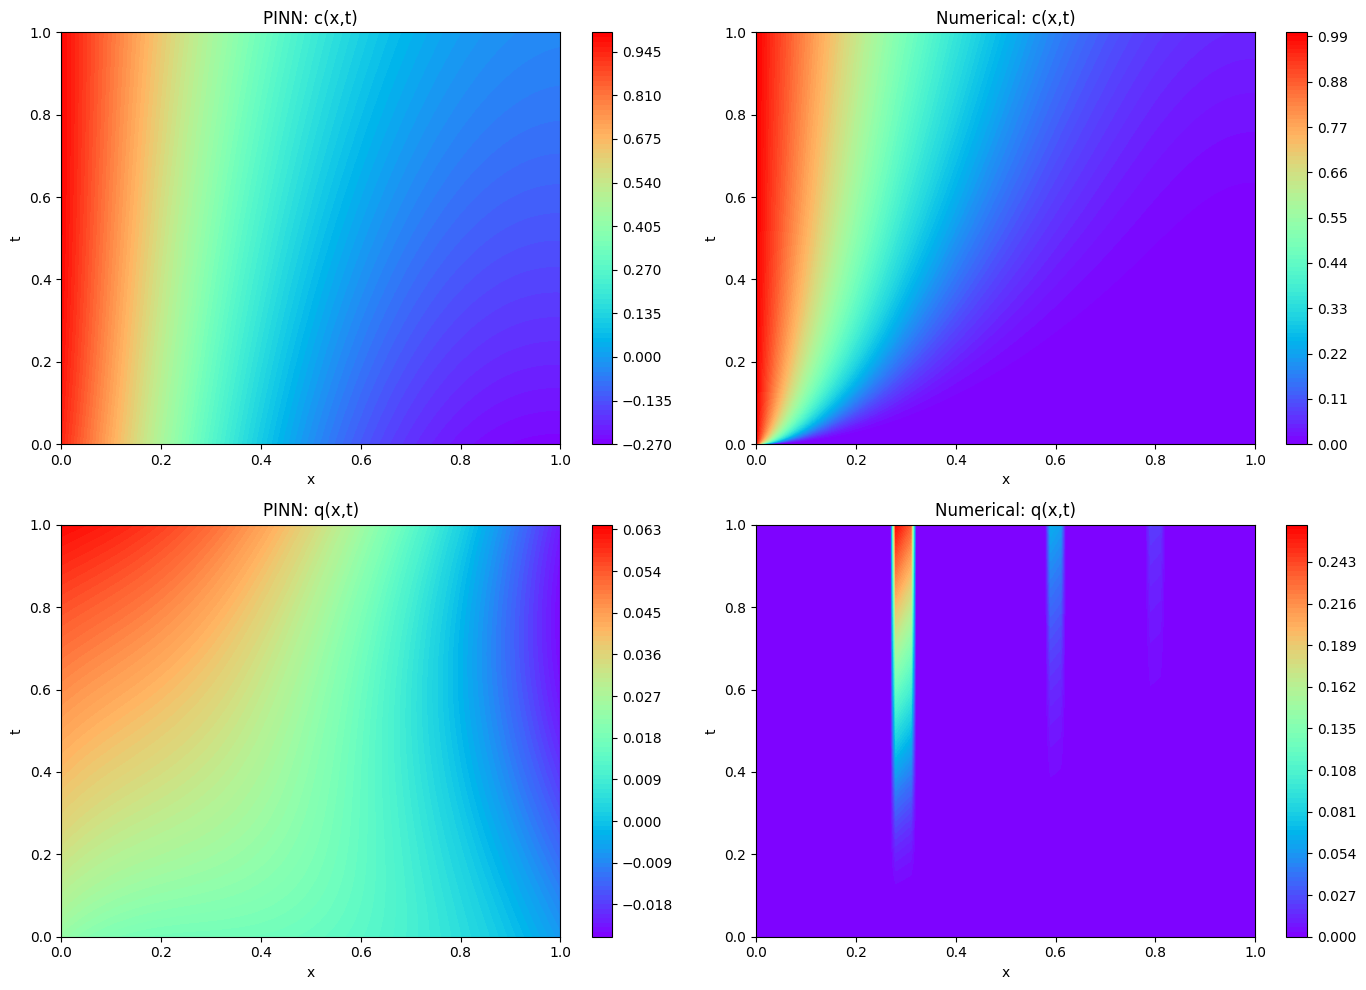

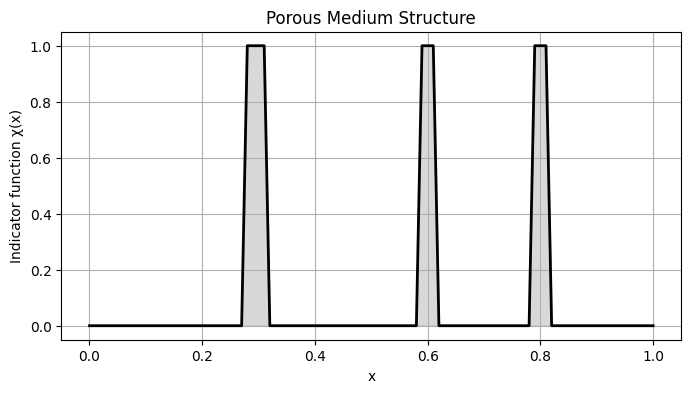

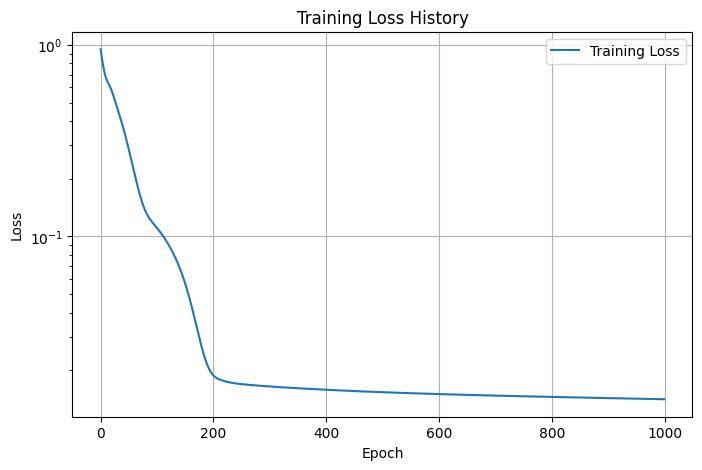

In [2]:
#%% Imports and Setup
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pyDOE import lhs
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
torch.manual_seed(31)
np.random.seed(31)

#%% Utility Functions
def gradients(outputs, inputs):
    # returns d(outputs)/d(inputs)
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

def nptoTensor(data):
    return torch.tensor(data, dtype=torch.float32, device=device)

def chi(x, solid_positions, delta):
    """
    Indicator function for the porous medium.
    x: tensor of spatial coordinates, shape (N,1)
    solid_positions: list of center positions for the solid nodes.
    delta: half-width of the solid region.
    Returns: tensor of same shape as x, with values 1 (inside solid) or 0.
    """
    chi_val = torch.zeros_like(x)
    for xs in solid_positions:
        chi_val += ((x > (xs - delta)) & (x < (xs + delta))).float()
    return torch.clamp(chi_val, 0, 1)

#%% Physical Parameters and Pore Structure
D     = 0.1    # Diffusion coefficient
c0    = 1.0    # Dirichlet BC for c at x=0
k_ads = 1.0    # Adsorption rate constant
k_des = 0.1    # Desorption rate constant
q_sat = 1.0    # Saturation capacity

# Define solid node positions (pore structure) and half-width delta
solid_positions = [0.3, 0.6, 0.8]
delta = 0.02

#%% Define the PINN (MLP) with Two Outputs: c and q
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        for layer in self.linears:
            nn.init.xavier_normal_(layer.weight, gain=1.0)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        # x: (N,2) input (x, t)
        for layer in self.linears[:-1]:
            x = self.activation(layer(x))
        x = self.linears[-1](x)
        # Output shape: (N,2) where column 0 is c(x,t) and column 1 is q(x,t)
        return x

    def loss(self, x_bc_c, y_bc_c, x_bc_q, y_bc_q, x_neumann, x_colloc):
        # --- Dirichlet BC for c at x=0 (all t) ---
        out_bc = self.forward(x_bc_c)
        c_bc = out_bc[:, 0:1]
        loss_bc_c = self.loss_function(c_bc, y_bc_c)

        # --- Dirichlet BC for q at t=0 (all x) ---
        out_bc_q = self.forward(x_bc_q)
        q_bc = out_bc_q[:, 1:2]
        loss_bc_q = self.loss_function(q_bc, y_bc_q)

        # --- Neumann BC for c at x=1 (c_x=0) ---
        x_neumann.requires_grad = True
        out_neumann = self.forward(x_neumann)
        c_neumann = out_neumann[:, 0:1]
        c_neumann_grad = gradients(c_neumann, x_neumann)[:, 0:1]
        loss_neumann = self.loss_function(c_neumann_grad, torch.zeros_like(c_neumann_grad))

        # --- PDE Residual at Collocation Points ---
        x_colloc.requires_grad = True
        out_colloc = self.forward(x_colloc)
        c_colloc = out_colloc[:, 0:1]
        q_colloc = out_colloc[:, 1:2]

        # Derivatives for c
        c_grad = gradients(c_colloc, x_colloc)
        c_x = c_grad[:, 0:1]
        c_t = c_grad[:, 1:2]
        c_xx = gradients(c_x, x_colloc)[:, 0:1]

        # Time derivative for q
        q_grad = gradients(q_colloc, x_colloc)
        q_t = q_grad[:, 1:2]

        # Evaluate indicator function using spatial coordinate (first column)
        chi_val = chi(x_colloc[:, 0:1], solid_positions, delta)

        # Langmuir kinetics: R(c,q)
        R = k_ads * c_colloc * (1 - q_colloc / q_sat) - k_des * q_colloc

        # PDEs:
        # Fluid-phase: c_t = D c_xx - χ R  =>  c_t - D c_xx + χ R = 0
        # Solid-phase: q_t = χ R       =>  q_t - χ R = 0
        res_c = c_t - D * c_xx + chi_val * R
        res_q = q_t - chi_val * R
        loss_pde = (res_c**2).mean() + (res_q**2).mean()

        total_loss = loss_bc_c + loss_bc_q + loss_neumann + loss_pde
        return total_loss

#%% Generate Training Data for the Porous Medium Problem
def trainingdata_porous(Nx, Nt, Nf):
    # Dirichlet BC for c: at x=0 for t in [0,1]
    t_bc = np.linspace(0, 1, Nt)[:, None]
    x_bc_c = np.hstack((np.zeros((Nt, 1)), t_bc))
    y_bc_c = c0 * np.ones((Nt, 1))

    # Dirichlet BC for q: initial condition t=0 for x in [0,1]
    x_space = np.linspace(0, 1, Nx)[:, None]
    t_initial = np.zeros((Nx, 1))
    x_bc_q = np.hstack((x_space, t_initial))
    y_bc_q = np.zeros((Nx, 1))

    # Neumann BC for c: at x=1 for t in [0,1] (c_x=0)
    t_neumann = np.linspace(0, 1, Nt)[:, None]
    x_neumann = np.hstack((np.ones((Nt, 1)), t_neumann))

    # Collocation points in the interior using Latin Hypercube Sampling (domain: [0,1]x[0,1])
    f_train = lhs(2, Nf)

    return x_bc_c, y_bc_c, x_bc_q, y_bc_q, x_neumann, f_train

# Set numbers for BC and collocation points
Nx = 100
Nt = 100
Nf = 10000

x_bc_c_np, y_bc_c_np, x_bc_q_np, y_bc_q_np, x_neumann_np, f_train_np = trainingdata_porous(Nx, Nt, Nf)
x_bc_c = nptoTensor(x_bc_c_np)
y_bc_c = nptoTensor(y_bc_c_np)
x_bc_q = nptoTensor(x_bc_q_np)
y_bc_q = nptoTensor(y_bc_q_np)
x_neumann = nptoTensor(x_neumann_np)
x_colloc = nptoTensor(f_train_np)

#%% Instantiate the Network
# Architecture: input dim 2, output dim 2.
layers = [2, 32, 32, 32, 32, 32, 32, 32, 32, 32, 2]
model = MLP(layers).to(device)

#%% Training Loop for the PINN
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
max_iter = 1000
loss_history = []

tic = time.time()
for i in range(max_iter):
    optimizer.zero_grad()
    loss = model.loss(x_bc_c, y_bc_c, x_bc_q, y_bc_q, x_neumann, x_colloc)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (i+1) % 100 == 0:
        print(f"Epoch {i+1}/{max_iter}, Loss: {loss.item():.6f}")
toc = time.time()
print(f"Total training time: {(toc-tic)/60:.2f} minutes")

# Save the trained model
model_path = "PorousSoluteTransport_PINN.pth"
torch.save(model.state_dict(), model_path)

#%% PINN Evaluation and Visualization
model.eval()
# Create a mesh grid on [0,1] x [0,1]
points = 100
x_eval = np.linspace(0, 1, points)
t_eval = np.linspace(0, 1, points)
X, T = np.meshgrid(x_eval, t_eval)
eval_points = np.hstack((X.reshape(-1,1), T.reshape(-1,1)))
eval_tensor = nptoTensor(eval_points)

with torch.no_grad():
    output = model(eval_tensor)
    c_pred = output[:, 0].cpu().numpy().reshape(X.shape)
    q_pred = output[:, 1].cpu().numpy().reshape(X.shape)

#%% Numerical Solution using Finite Difference Method
points_in_x = 101
x_num = np.linspace(0, 1, points_in_x)
dx = x_num[1] - x_num[0]
dt = 0.5 * dx**2 / D   # stability condition for diffusion; may require adjustment for reaction
t_final = 1.0
points_in_t = int(t_final/dt) + 1
t_num = np.linspace(0, t_final, points_in_t)
dt = t_num[1] - t_num[0]

def chi_np(x, solid_positions, delta):
    chi_val = np.zeros_like(x)
    for xs in solid_positions:
        chi_val += ((x > (xs - delta)) & (x < (xs + delta))).astype(float)
    return np.clip(chi_val, 0, 1)

chi_array = chi_np(x_num, solid_positions, delta)

def R(c_val, q_val):
    return k_ads * c_val * (1 - q_val/q_sat) - k_des * q_val

# Initialize numerical arrays for c and q: shape (time, space)
c_num = np.zeros((points_in_t, points_in_x))
q_num = np.zeros((points_in_t, points_in_x))

# Initial conditions: c=0, q=0 at t=0 everywhere
c_num[0, :] = 0.0
q_num[0, :] = 0.0

# Time stepping
for n in range(points_in_t - 1):
    # Boundary at x=0: c = c0 (Dirichlet)
    c_num[n+1, 0] = c0
    # Interior nodes
    for i in range(1, points_in_x - 1):
        reaction = R(c_num[n, i], q_num[n, i])
        c_num[n+1, i] = c_num[n, i] + dt*( D*(c_num[n, i+1] - 2*c_num[n, i] + c_num[n, i-1])/(dx**2) - chi_array[i]*reaction )
        q_num[n+1, i] = q_num[n, i] + dt*( chi_array[i]*reaction )
    # Boundary at x=1: Neumann for c (c_x = 0) -> set c[n+1,-1] = c[n+1,-2]
    c_num[n+1, -1] = c_num[n+1, -2]
    # For q, mirror the neighbor (or use the interior update)
    q_num[n+1, -1] = q_num[n+1, -2]

#%% Plotting: Compare PINN and Numerical Solutions
# For numerical solution, create meshgrid
X_num, T_num = np.meshgrid(x_num, t_num)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top row: c(x,t)
cs0 = axes[0, 0].contourf(X, T, c_pred, levels=100, cmap='rainbow')
axes[0, 0].set_title("PINN: c(x,t)")
axes[0, 0].set_xlabel("x")
axes[0, 0].set_ylabel("t")
fig.colorbar(cs0, ax=axes[0, 0])

cs1 = axes[0, 1].contourf(X_num, T_num, c_num, levels=100, cmap='rainbow')
axes[0, 1].set_title("Numerical: c(x,t)")
axes[0, 1].set_xlabel("x")
axes[0, 1].set_ylabel("t")
fig.colorbar(cs1, ax=axes[0, 1])

# Bottom row: q(x,t)
cs2 = axes[1, 0].contourf(X, T, q_pred, levels=100, cmap='rainbow')
axes[1, 0].set_title("PINN: q(x,t)")
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel("t")
fig.colorbar(cs2, ax=axes[1, 0])

cs3 = axes[1, 1].contourf(X_num, T_num, q_num, levels=100, cmap='rainbow')
axes[1, 1].set_title("Numerical: q(x,t)")
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel("t")
fig.colorbar(cs3, ax=axes[1, 1])

plt.tight_layout()
plt.savefig("Comparison_PINN_Numerical.png", dpi=300)
plt.show()

#%% Plot the Porous Medium Structure
plt.figure(figsize=(8, 4))
plt.plot(x_num, chi_array, 'k-', linewidth=2)
plt.fill_between(x_num, chi_array, alpha=0.3, color='gray')
plt.xlabel("x")
plt.ylabel("Indicator function χ(x)")
plt.title("Porous Medium Structure")
plt.grid(True)
plt.savefig("PorousMediumStructure.png", dpi=300)
plt.show()

#%% Plot Training Loss History
plt.figure(figsize=(8,5))
plt.semilogy(loss_history, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)
plt.savefig("TrainingLoss_PorousPINN.png", dpi=300)
plt.show()
